## Implementing Expectation Maximization for MNIST dataset, with PCA for dimensionality reduction


In this project, we will implement the EM algorithm for fitting a Gaussian mixture model for the MNIST dataset. We reduce the dataset to be only two cases, of digits 2 and 6 only. Thus, we will fit GMM with $C = 2$. Use the data file data.mat or data.dat. True label of the data are also provided in label.mat and label.dat


The matrix images is of size 784-by-1990, i.e., there are totally 1990 images, and each column of the matrix corresponds to one image of size 28-by-28 pixels (the image is vectorized; the original image can be recovered by map the vector into a matrix). 

First we will use PCA to reduce the dimensionality of the data before applying to EM. We will put all 6 and 2 digits together, to project the original data into 5-dimensional vectors.

---

First, we begin by loading up MNIST dataset along with all the packages required for the analysis. Now that our data is properly organized, we can select individual instances of each digit 2 and 6 respectively, reshape each, and plot them in image form. Both of these output are shown below:

In [1]:
import numpy as np
import scipy as sp
from __future__ import print_function
import numpy as np
import math
import sklearn.preprocessing
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats
import scipy.io
import seaborn as sns
from matplotlib import cm
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
import pandas as pd
mnist_labels = np.loadtxt('label.dat')
mnist_data = np.loadtxt('data.dat')

### Raw '2' and '6' Digit Plot:

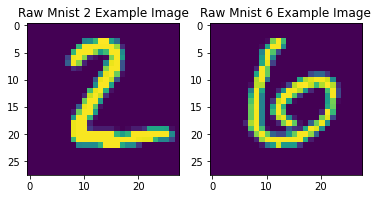

In [2]:
plt.figure(figsize=(6,6))
plt.subplot(121)
digit_two_instance_index = np.argwhere(mnist_labels == 2.0)[0][0]
digit_two_instance_reshaped = np.reshape(mnist_data[:,digit_two_instance_index],(28,28)).T
plt.imshow(digit_two_instance_reshaped)
plt.title('Raw Mnist 2 Example Image')
plt.subplot(122)
digit_six_instance_index = np.argwhere(mnist_labels == 6.0)[0][0]
digit_six_instance_reshaped = np.reshape(mnist_data[:,digit_six_instance_index],(28,28)).T
plt.imshow(digit_six_instance_reshaped)
plt.title('Raw Mnist 6 Example Image')
plt.show()

As we can see from visualizing two random images from each class above, each of the labels clearly represents the number it corresponds to.

---

### Problem Formulation:

We wish to learn the proper parameters of a distribution that maximizes the log likelihood function:

$$l(\theta;D) = \log \prod_{i=1}^m \bigg( \sum_{z^i=1}^{K} p(x^i,z^i|\theta)  \bigg)$$

Since the latent variable is not observed directly we cannot directly know which component gaussian each datapoint is from without some further math. We decide to take the expectation over the posterior distribution $z^i$ conditioning the distribution on our data. This takes the following general form:

$$l(\theta;D) \ge f(\theta) = \mathbb{E}_{q(z^1,z^2,...,z^m)} \bigg[ \log \prod_{i=1}^{m} \bigg( \sum_{z^i=1}^{K} p(x^i,z^i|\theta) \bigg) \bigg]$$


### Initialization:

$$\pi_0 = \  random \ initialization$$

$$\mu_0 = \  random \ initialization$$

$$\Sigma_0 = \  random \ initialization$$

$$k = \  number \ of \ Gaussians$$

### E-Step (Expectation):

In the E-Step or Expectation Step, we wish to estimate the responsibility or expectation of $\tau_i^k$ (which we use as a variable to represent $\mathbb{E}_{q(z^1,z^2,...,z^m)}$ in the general formulation above) as a way around this problem. In order to accomplish this, we apply Bayes rule to derive an estimation of the values.  

$$\tau_i^k = p(z_i^k|x^i) = \frac{p(x^i,z_k^i)}{p(x^i)} = \frac{p(x^i|z_k^i) p(z_k^i)}{\sum_{k=1}^{k} p(x^i|z_k^i) p(z_k^i)}  = \frac{\pi_k \mathcal{N}(x^i|\mu_k,\Sigma_k)}{\sum_{k=1}^{k} \pi_{k} \mathcal{N} (x^i|\mu_{k},\Sigma_{k})} $$ 

We can solve for $\tau_i^k$ using our randomly initialized $\mu$, $\pi$, and $\Sigma$. This output represents our expectation of the posterior, which we then input to our maximization step to maximize the loglikelihood of our posterior by updating our distributional parameters $\mu$, $\pi$, and $\Sigma$ according to our current estimates of $\tau_i^k$.


---

### M-Step (Maximization):

Going back to our initial formulations we have:

$$f(\theta) = \mathbb{E}_{q(z^1,z^2,...,z^m)} \bigg[ \log \prod_{i=1}^{m} p(x^i,z^i|\theta) \bigg] = \sum_{i=1}^{m} \mathbb{E}_{p(x^i,z^i|\theta^t)} \log [ p(x^i,z^i|\theta)] = \sum_{i=1}^{m} \mathbb{E}_{p(x^i,z^i|\theta^t)} \bigg[ \log \pi_{z^i}\mathcal{N}(x^i|\mu_{z^i},\Sigma_{z^i}) \bigg]$$

Expand log of Gaussian density $\log \mathcal{N}(x^i|\mu_{z^i},\Sigma_{z^i})$:

$$f(\theta) = \sum_{i=1}^{m} \mathbb{E}_{p(x^i,z^i|\theta^t)} \bigg[ \log(\pi_{z^i}) - \frac{1}{2}(x^i - \mu_{z^i})^T \Sigma_{z^i}^{-1}(x^i - \mu_{z^i}) - \frac{1}{2} \log | \Sigma_{z^i}| - \frac{n}{2} \log (2\pi) \bigg]$$

Substitute $\tau_k^i$ for $\mathbb{E}_{p(x^i,z^i|\theta^t)}$ yields to following:

$$f(\theta) = \sum_{i=1}^{m} \sum_{k=1}^{k} \tau_{k}^{i} \bigg[ \log(\pi_{k}) - \frac{1}{2}(x^i - \mu_{k})^T \Sigma_{k}^{-1}(x^i - \mu_{k}) - \frac{1}{2} \log | \Sigma_{k}| - \frac{n}{2} \log (2\pi) \bigg]$$


Now that we have our expanded formulation of the problem we wish to solve for our new updated values of $\mu$ , $\pi$, and $\Sigma$. In order to do this we take the partial derivatives of the function with respect to each of these variables (independently that is), set to zero and solve for their values. We begin with solving for our gaussian mixing coefficients $\pi$. In order to do this, we wish to constrain the optimization problem by finding $\pi_k$, and $\Sigma^K_{k=1} \pi_k = 1$. Thus, forming the LaGrangian we have:


$$L = \sum_{i=1}^{m} \sum_{k=1}^{k} \tau_{k}^{i} \bigg[ \log(\pi_{k}) - \frac{1}{2}(x^i - \mu_{k})^T \Sigma_{k}^{-1}(x^i - \mu_{k}) - \frac{1}{2} \log | \Sigma_{k}| - \frac{n}{2} \log (2\pi) \bigg] + \lambda(1- \sum_{i=1}^K \pi_k)$$

Next taking the partial derivative (where most terms cancel), setting the equation to zero:

$$\frac{\partial L}{\partial \pi_k} = \sum_{i=1}^{m} \frac{\tau_{k}^i}{\pi_k} - \lambda = 0 $$

Reducing from the above form, we have:

$$\pi_k = \frac{1}{\lambda} \sum_{i=1}^m \tau_k^i $$

The resulting value when computed using the $\tau_k^i$ values from the expectations step will yield our updated values for $pi_k$ in the next iteration of the algorithm. Next, we move on to solving for our updated $\mu_k$ values. We start with the following using the same approach as with $pi_k$ just without our LaGrangian step as $\mu$ is not constrained in this way:

$$\frac{\partial L}{\partial \mu_k} = \sum_{i=1}^{m} \sum_{k=1}^{k} \tau_{k}^{i} \bigg[ \log(\pi_{k}) - \frac{1}{2}(x^i - \mu_{k})^T \Sigma_{k}^{-1}(x^i - \mu_{k}) - \frac{1}{2} \log |\Sigma_{k} |- \frac{n}{2} \log (2\pi) \bigg] $$


Majority of terms reduce/cancel, and we are left with before applying partial derivative function to remaining terms:

$$\frac{\partial L}{\partial \mu_k} = \sum_{i=1}^{m} \sum_{k=1}^{k} \tau_{k}^{i} [- \frac{1}{2}(x^i - \mu_{k})^T \Sigma_{k}^{-1}(x^i - \mu_{k})] = 0$$

Reducing the inner portion by applying the partial derivative function to the remaining terms we have:

$$ \frac{\partial L}{\partial \mu_k} = \sum_{i=1}^{m} [\tau_k^i \Sigma^{-1} x_i + \tau_k^i \Sigma^{-1} \mu_i] = 0 $$

Simplifying we finally reach:

$$\mu_k = \frac{\sum_{i=1}^{m} \tau_k^i x^i}{\sum_{i=1}^{m} \tau_k^i} $$


Again, we use our previously computed $\tau_k^i$ values to compute our updated $\mu$ values. Next, we take the same partial differentiation approach to solving for $\Sigma_k$:

$$\frac{\partial L}{\partial \Sigma_k} = \sum_{i=1}^{m} \sum_{k=1}^{k} \tau_{k}^{i} \bigg[ \log(\pi_{k}) - \frac{1}{2}(x^i - \mu_{k})^T \Sigma_{k}^{-1}(x^i - \mu_{k}) - \frac{1}{2} \log |\Sigma_{k}| - \frac{n}{2} \log (2\pi) \bigg]$$

Majority of terms reduce/cancel, and we are left with before applying partial derivative function to remaining terms:

$$\frac{\partial L}{\partial \Sigma_k} = \sum_{i=1}^{m} \sum_{k=1}^{k} \tau_{k}^{i} \bigg[  - \frac{1}{2}(x^i - \mu_{k})^T \Sigma_{k}^{-1}(x^i - \mu_{k}) - \frac{1}{2} \log |\Sigma_{k}| \bigg] $$


Simplifying our new Sigma is:

$$ \Sigma_k = \frac{\sum_{i=1}^{m} \tau_k^i(x^i - \mu_{k})(x^i - \mu_{k})^T }{\sum_{i=1}^{m} \tau_k^i} $$

At this point we have found all of our updated values of the distributional parameters. Now, we use our updated new parameters to solve for an updated once again $\tau _k^i$ by returning to our expectation step and following the algorithm through once more until we reach a solution that is sufficient.


---

### GMM Model Preprocessing and PCA:

In [3]:
from sklearn.cluster import KMeans
from scipy.stats import multivariate_normal as mvn
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
def mu_reshape_transform(U,Lambda,New_Mu,Og_Mu,out_shape):
    formatted_L = (np.sqrt(np.array(Lambda))[:,np.newaxis])
    formatted_om = Og_Mu
    mult = formatted_L* New_Mu[:,np.newaxis]
    dotted = np.dot(U,mult) + formatted_om
    dotted_re = np.reshape(dotted,(out_shape,out_shape))
    return dotted_re

def cov_transform(U,Lambda,New_Cov):
    formatted_L = (np.sqrt(np.array(Lambda))[:,np.newaxis])
    first = formatted_L * U.T
    second = np.dot(New_Cov,first)
    third = formatted_L * second
    fourth = np.dot(U,third)
    return fourth


num_pcs = 5
original_mean = np.average(mnist_data,axis=1)[:,np.newaxis]
mnist_centered = mnist_data - original_mean
num_pix,num_images = mnist_centered.shape
cov_mnist =  np.dot(mnist_centered,mnist_centered.T) / (num_images)
U,Eigen_Vals,Vh = np.linalg.svd(cov_mnist)
k_eigvectors = U[:,0:num_pcs]
k_eigvals = Eigen_Vals[0:num_pcs]
mnist_pca = (np.dot(k_eigvectors.T,mnist_centered) / (np.sqrt(np.array(k_eigvals))[:,np.newaxis])).T


### Mnist PCA Eigenvalues Visualized:

In order to verify our SVD has the proper sorting we can visualize our eigenvalues as a good debugging check which is displayed below:

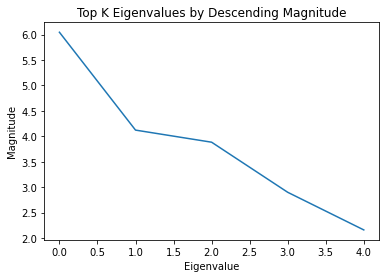

In [4]:
plt.plot(k_eigvals)
plt.title('Top K Eigenvalues by Descending Magnitude')
plt.ylabel('Magnitude')
plt.xlabel('Eigenvalue')
plt.show()

### Mnist PCA Weights Visualized:

Now that we have applied PCA to our dataset we can visualize our reconstructed dataset based upon the feature weights PCA employed in reducing the feature space. These weights and their magnitudes are demonstrated below in via heat plot:


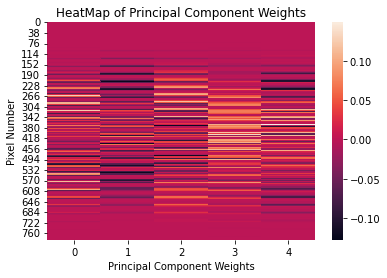

In [5]:
sns.heatmap(k_eigvectors)
plt.title('HeatMap of Principal Component Weights')
plt.ylabel('Pixel Number')
plt.xlabel('Principal Component Weights')
plt.show()

### Mnist PCA Projection Visualized:

Similarly, to the above PCA weights visualization, we can also look at a heatmap of our now projected dataset to get a better understanding of its structure. The respective heatmap is shown below:

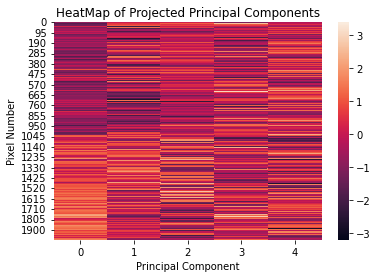

In [6]:
sns.heatmap(mnist_pca)
plt.title('HeatMap of Projected Principal Components')
plt.ylabel('Pixel Number')
plt.xlabel('Principal Component')
plt.show()

### Mnist Projection on Principal Components 0 and 1:

Finally, we can get one last additional visualization of our PCA projected dataset by plotting for visual purposes the first two principal components of our new data. We can use coloring of respective '2' and '6' labels to better understand the seperation of the two classes in our new PCA projection. This chart is shown below:

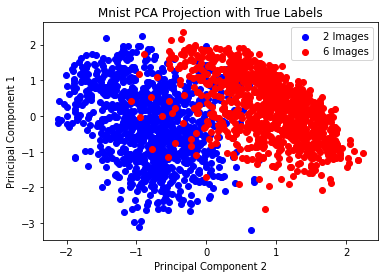

In [7]:
mnist_pca_0 = mnist_pca[:,0]
mnist_pca_0_2 = mnist_pca_0[np.where(mnist_labels == 2)]
mnist_pca_0_6 = mnist_pca_0[np.where(mnist_labels == 6)]
mnist_pca_1 = mnist_pca[:,1]
mnist_pca_1_2 = mnist_pca_1[np.where(mnist_labels == 2)]
mnist_pca_1_6 = mnist_pca_1[np.where(mnist_labels == 6)]
plt.scatter(x=mnist_pca_0_2,y=mnist_pca_1_2,c='b',label='2 Images')
plt.scatter(x=mnist_pca_0_6, y=mnist_pca_1_6,c='r',label='6 Images')
plt.legend()
plt.title('Mnist PCA Projection with True Labels')
plt.ylabel('Principal Component 1')
plt.xlabel('Principal Component 2')
plt.show()

Interestingly enough, our 2D chart of PC0 and PC1 display a pretty clear decision boundary for the 2 and 6 image labels. This shows just how well PCA has exposed non-trivial variances within the dataset while also simplifying our feature space making model implementation less computationally expensive than before.


### Gaussian Mixture Model Implementation (Dynamic Non-Seeded):

With our dataset now reduced via PCA we can move to the implementation of our GMM model. The collapsed code and output are accessible below:

In [8]:
K = 2
pi = np.random.random(K)

pi = pi/np.sum(pi)

mu = np.random.randn(K,mnist_pca.shape[1])
mu_old = mu.copy()
sigma = []
for i in range(K):
    inital_cov_i = np.random.randn(mnist_pca.shape[1],mnist_pca.shape[1])
    sigma.append(inital_cov_i @ inital_cov_i.T + np.identity(mnist_pca.shape[1]))

tau = np.full((mnist_pca.shape[0], K), fill_value=0.)

maxIter = 50
tolerance = 1e-3
log_likelihood = []
accuracy_list = []
stored_t = []


for i in range(maxIter):
    
    
    for ks in range(K):
        tau[:, ks] = pi[ks] * mvn.pdf(mnist_pca, mu[ks], sigma[ks])
    sum_tau = np.sum(tau, axis=1)
    log_likelihood.append(np.sum(np.log10(sum_tau)))
    sum_tau = sum_tau[:,np.newaxis]  
    
    tau = np.divide(tau, np.tile(sum_tau, (1, K)))
    stored_t.append(np.copy(tau))
    
    for ks2 in range(K):
        pi[ks2] = np.sum(tau[:, ks2])/ num_images
        mu[ks2] = mnist_pca.T @ tau[:,ks2] / np.sum(tau[:,ks2], axis = 0)
        centered_k = mnist_pca - np.tile(mu[ks2], (num_images,1))
        sigma[ks2] = centered_k.T @ np.diag(tau[:,ks2]) @ centered_k / np.sum(tau[:,ks2], axis = 0)
    gmm_labels = np.argmax(tau,axis=1)
    gmm_labels1 = np.where(gmm_labels == 0,6,2)
    gmm_labels2 = np.where(gmm_labels == 0,2,6)
    number_of_samples = gmm_labels.shape[0]
    number_correct1 = np.sum(mnist_labels == gmm_labels1)
    number_correct2 = np.sum(mnist_labels == gmm_labels2)
    gmm_percent_correct1 = number_correct1/number_of_samples
    gmm_percent_correct2 = number_correct2/number_of_samples
    
    if gmm_percent_correct1 > gmm_percent_correct2:
        iteration_accuracy = gmm_percent_correct1
    else:
        iteration_accuracy = gmm_percent_correct2
    accuracy_list.append(iteration_accuracy)
  
    if np.linalg.norm(mu-mu_old) < tolerance:
        
        break
    mu_old = mu.copy()
    if i==(maxIter-1):

        break

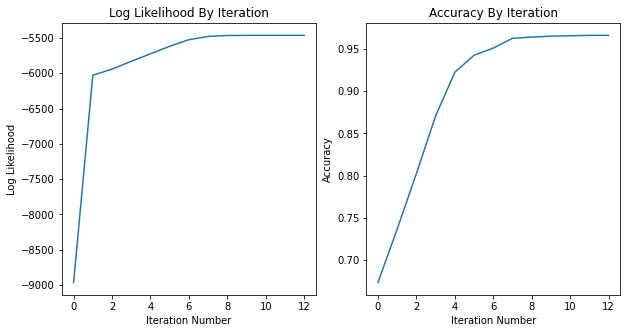

In [9]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(log_likelihood)
plt.title('Log Likelihood By Iteration')
plt.xlabel('Iteration Number')
plt.ylabel('Log Likelihood')
plt.subplot(122)
plt.plot(np.array(accuracy_list))
plt.title('Accuracy By Iteration')
plt.xlabel('Iteration Number')
plt.ylabel('Accuracy')
plt.show()

As we can see from the chart output of the GMM implementation above, the model clearly at each iteration shows maximization of log likelihood and eventual convergence both with respect to accuracy and log likelihoods. This result demonstrates our model is effectively operating and learning.

### Reporting Misclassification Rates Under a Static Seeded Iteration:

To explore the by digit mis-match rates it is necessary to setup another run of the algorithm this time setting a static random number generation seed to make the results constant and reproducible. Additionally, another important reason to do this is because we are using an unsupervised algorithm which fundamentally is agnostic to wherever gaussian 0 represent 2 and gaussian 1 represents digit 6 and vice versa. This is because each random iteration will change the ordering of the label and in order to properly report by digit mis-match we must be able to visually check our model's output label mean vectors to compare them with the true labels properly.

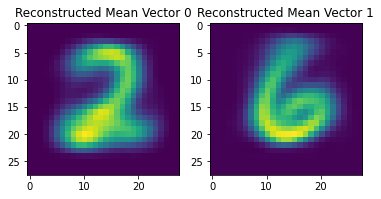

-------True Positive = 2 Classification Rate -------
0.992849846782431
-------True Negative = 6 Classification Rate -------
0.9406528189910979
------- Precision Rate -------
0.9418604651162791
------- Negative Predictive Value Rate -------
0.9926931106471816
------- Accuracy Rate -------
0.9663316582914573


In [10]:
def gmm_steady_state(mnist_data):
    num_pcs = 5
    original_mean = np.average(mnist_data,axis=1)[:,np.newaxis]
    mnist_centered = mnist_data - original_mean
    num_pix,num_images = mnist_centered.shape
    cov_mnist =  np.dot(mnist_centered,mnist_centered.T) / (num_images)
    U,Eigen_Vals,Vh = np.linalg.svd(cov_mnist)
    k_eigvectors = U[:,0:num_pcs]
    k_eigvals = Eigen_Vals[0:num_pcs]
    np.random.seed(10)
    K = 2
    pi = np.random.random(K)

    pi = pi/np.sum(pi)

    mu = np.random.randn(K,mnist_pca.shape[1])
    mu_old = mu.copy()
    sigma = []
    for i in range(K):
        inital_cov_i = np.random.randn(mnist_pca.shape[1],mnist_pca.shape[1])
        sigma.append(inital_cov_i @ inital_cov_i.T + np.identity(mnist_pca.shape[1]))

    #tau = np.zeros((num_images,K))
    tau = np.full((mnist_pca.shape[0], K), fill_value=0.)

    maxIter = 100
    tolerance = 1e-3
    log_likelihood = []
    accuracy_list = []
    stored_t = []


    for i in range(maxIter):


        for ks in range(K):
            tau[:, ks] = pi[ks] * mvn.pdf(mnist_pca, mu[ks], sigma[ks])

        sum_tau = np.sum(tau, axis=1)
        log_likelihood.append(np.sum(np.log10(sum_tau)))
        sum_tau = sum_tau[:,np.newaxis]  
        tau = np.divide(tau, np.tile(sum_tau, (1, K)))
        stored_t.append(np.copy(tau))

        for ks2 in range(K):
            pi[ks2] = np.sum(tau[:, ks2])/ num_images
            mu[ks2] = mnist_pca.T @ tau[:,ks2] / np.sum(tau[:,ks2], axis = 0)
            cov_k = mnist_pca - np.tile(mu[ks2], (num_images,1))
            sigma[ks2] = cov_k.T @ np.diag(tau[:,ks2]) @ cov_k / np.sum(tau[:,ks2], axis = 0)

        if np.linalg.norm(mu-mu_old) < tolerance:

            break
        mu_old = mu.copy()
        if i==(maxIter-1):

            break
    return tau,k_eigvectors,k_eigvals,mu,original_mean

tau_r,k_eigvectors_r,k_eigvals_r,mu_r,original_mean_r = gmm_steady_state(mnist_data)
plt.figure(figsize=(6,6))
mean_re_1_r = mu_reshape_transform(k_eigvectors_r,k_eigvals_r,mu_r[0,:],original_mean_r,28).T
plt.subplot(121)
plt.imshow(mean_re_1_r)
plt.title('Reconstructed Mean Vector 0')
plt.subplot(122)
mean_re_2_r = mu_reshape_transform(k_eigvectors_r,k_eigvals_r,mu_r[1,:],original_mean_r,28).T
plt.imshow(mean_re_2_r)
plt.title('Reconstructed Mean Vector 1')
plt.show()
gmm_labels_r = np.argmax(tau_r,axis=1)
gmm_labels_r = np.where(gmm_labels_r == 0,2,6)
from sklearn.metrics import confusion_matrix
confumat = confusion_matrix(mnist_labels,gmm_labels_r)
print('-------True Positive = 2 Classification Rate -------')
print(confumat[0,0] / (confumat[0,0] + confumat[1,0]))
print('-------True Negative = 6 Classification Rate -------')
print(confumat[1,1] / (confumat[1,1] + confumat[0,1]))
print('------- Precision Rate -------')
print(confumat[0,0] / (confumat[0,0] + confumat[0,1]))
print('------- Negative Predictive Value Rate -------')
print(confumat[1,1] / (confumat[1,1] + confumat[1,0]))
print('------- Accuracy Rate -------')
print((confumat[1,1] + confumat[0,0]) / (confumat[1,1] + confumat[0,1] + confumat[0,0] +confumat[1,0]))

As we can see from the output above, our model does quite well in the general case with an astonishing 96% accuracy. It seems that given the True Positive and True Negative rates that our model is better at classifying 2's, and has slightly worse performance on 6's. However, the difference in performance between the classes is fairly marginal.

### Reconstructed GMM Means:

After running our GMM implementation (this time using dynamic non-seeded initializations) we can plot and reconstruct our model's final 2 gaussian mean vectors. Their reshaped forms are plotted below:

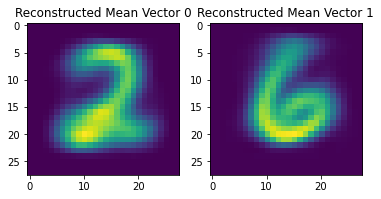

In [11]:
plt.figure(figsize=(6,6))
mean_re_1 = mu_reshape_transform(k_eigvectors,k_eigvals,mu[0,:],original_mean,28).T
plt.subplot(121)
plt.imshow(mean_re_1)
plt.title('Reconstructed Mean Vector 0')
plt.subplot(122)
mean_re_2 = mu_reshape_transform(k_eigvectors,k_eigvals,mu[1,:],original_mean,28).T
plt.imshow(mean_re_2)
plt.title('Reconstructed Mean Vector 1')
plt.show()

As we can clearly see the GMM mean vectors depict proper seperation between 2- and 6-digit representations. This is a good sign that our algorithm has been able to find some distinctive differences between them.

### Reconstructed GMM Covariance Matrices:

Just as we reconstructed our final GMM mean vectors, we can also reproject our final covariance matrices into the original space for visualization. The outputs are plotted below:

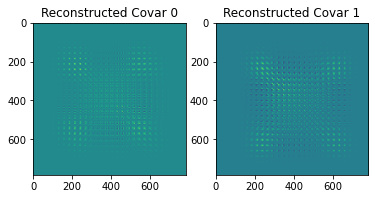

In [12]:
plt.figure(figsize=(6,6))
plt.subplot(121)
cov_trans_0 = cov_transform(k_eigvectors,k_eigvals,sigma[0])
plt.imshow(cov_trans_0)
plt.title('Reconstructed Covar 0')
plt.subplot(122)
cov_trans_1 = cov_transform(k_eigvectors,k_eigvals,sigma[1])
plt.imshow(cov_trans_1)
plt.title('Reconstructed Covar 1')
plt.show()

Interpreting the covariance matrices visualizations can be a bit ambiguous. However, we can see on close inspection that they do certainly have some underlying structure. In the first matrix we can clearly see the figure is positioned in the bottom right of the plane with an 'X' shape composition. On the other hand, the second covariance matrix seems to be a bit more centered in the plane and represents a more cross like composition. The differences between the two should help understand the inherent differences in structure for 2 and 6 representations.

### Reconstructed PCA Plot with Interactive GMM Assignment Inspection:

Using our initial 2D PCA plot from above we can now fit our new labels to it along with some image annotations to better understand where our marginal numbers lie on the grid, and verify that our algorithm is classifying properly. Additionally, I have included yet another slider which allows the user to look back in time at the assignment labels and visualize iteration by iteration the changing assignments of each point. Also of note is the plot points that are on decision boundaries will take on the color purple as their probability estimates for red and blue are somewhat close resulting in this mixture of soft assignment.

In [13]:
images_album = np.reshape(mnist_data,(28,28,1990))
images_album_index_2s = np.random.choice(np.where(mnist_labels == 2)[0],size=25)
images_album_index_6s = np.random.choice(np.where(mnist_labels == 6)[0],size=25)   
images_album_index = np.concatenate((images_album_index_2s,images_album_index_6s),axis=0)
def color_pca_plot(iter_view): 
    num_iter = len(stored_t) -1
    red = stored_t[iter_view][:,0][:,np.newaxis]
    blue = stored_t[iter_view][:,1][:,np.newaxis]
    green = np.zeros(num_images)[:,np.newaxis]
    color_tau = np.concatenate((red,green,blue),axis=1)
    fig, ax = plt.subplots(figsize=(7,7))
    iso_pca = np.vstack((mnist_pca[:,0], mnist_pca[:,1]))
    ax.scatter(mnist_pca[:,0], mnist_pca[:,1], c=color_tau)
    ax.set_title('Mnist Data Soft Cluster Labels by Iteration')
    ax.set_ylabel('Standardize PC 1')
    ax.set_xlabel('Standardize PC 0')
    for i in images_album_index:
        solo_image = images_album[:,:,i].T
        imagebox = OffsetImage(solo_image, zoom=0.7)
        ab = AnnotationBbox(imagebox, iso_pca.T[i], pad=0.01)
        ax.add_artist(ab)
widgets.interact(color_pca_plot,iter_view=widgets.IntSlider(min=0,max=len(stored_t)-1,step=1,value=len(stored_t)-1))
plt.show()

interactive(children=(IntSlider(value=12, description='iter_view', max=12), Output()), _dom_classes=('widget-i…

As we can clearly see from the plot above, the GMM implementation seems to do a very fine job at properly separating the dataset. It is also very interesting to see the images annotation especially those lying near boundaries as these digits are somewhat undistinguishable for even human eyes. Additionally, be playing back our graph though iteration 0 to our final iteration we can see just how nicely the algorithm progresses and better understand the functionality behind the black box of unsupervised learning.

---

### GMM Accuracy:

In order to better understand the performance of the Gaussian Mixture Model implementation above, we can run the model on multiple random initializations and see how our accuracy value results fare. The results are shown below:

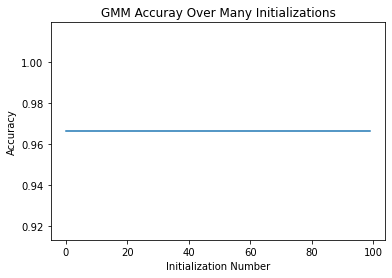

In [14]:
gmm_accuracy_list = []
for i in range(100): 
    K = 2
    pi = np.random.random(K)
    pi = pi/np.sum(pi)
    mu = np.random.randn(K,mnist_pca.shape[1])
    mu_old = mu.copy()
    sigma = []
    for i in range(K):
        inital_cov_i = np.random.randn(mnist_pca.shape[1],mnist_pca.shape[1])
        sigma.append(inital_cov_i @ inital_cov_i.T + np.identity(mnist_pca.shape[1]))
    tau = np.full((mnist_pca.shape[0], K), fill_value=0.)
    maxIter = 100
    tolerance = 1e-3
    for i in range(maxIter):
        for ks in range(K):
            tau[:, ks] = pi[ks] * mvn.pdf(mnist_pca, mu[ks], sigma[ks])
        sum_tau = np.sum(tau, axis=1)
        sum_tau = sum_tau[:,np.newaxis]  
        tau = np.divide(tau, np.tile(sum_tau, (1, K)))
       
        for ks2 in range(K):
            pi[ks2] = np.sum(tau[:, ks2])/ num_images
            mu[ks2] = mnist_pca.T @ tau[:,ks2] / np.sum(tau[:,ks2], axis = 0)
            cov_k = mnist_pca - np.tile(mu[ks2], (num_images,1))
            sigma[ks2] = cov_k.T @ np.diag(tau[:,ks2]) @ cov_k / np.sum(tau[:,ks2], axis = 0)

        if np.linalg.norm(mu-mu_old) < tolerance:
            break
        mu_old = mu.copy()
        if i==(maxIter-1):
            break
            
    gmm_labels = np.argmax(tau,axis=1)
    gmm_labels1 = np.where(gmm_labels == 0,6,2)
    gmm_labels2 = np.where(gmm_labels == 0,2,6)
    number_of_samples = gmm_labels.shape[0]
    number_correct1 = np.sum(mnist_labels == gmm_labels1)
    number_correct2 = np.sum(mnist_labels == gmm_labels2)
    gmm_percent_correct1 = number_correct1/number_of_samples
    gmm_percent_correct2 = number_correct2/number_of_samples

    if gmm_percent_correct1 > gmm_percent_correct2:
        iteration_accuracy = gmm_percent_correct1
    else:
        iteration_accuracy = gmm_percent_correct2
    gmm_accuracy_list.append(np.copy(iteration_accuracy))
gmm_accuracy_array = np.array(gmm_accuracy_list)
plt.plot(gmm_accuracy_array)
plt.title('GMM Accuray Over Many Initializations')
plt.xlabel('Initialization Number')
plt.ylabel('Accuracy')
plt.show()

As we can clearly see, our GMM is agnostic to initialization choice and has a constant accuracy rate. This is not a bug in the code, but instead and example of the great properties of GMM's. Under a dataset of reasonable size with a reasonably high number of iterations allowed, we are guaranteed to reach our global maximum regardless of initialization conditions so long as we have enough iterations overhead permitted.

### K-means Reconstructed Mean Vectors:

In order to see just how well gaussian mixture modeling performs, we can compare it to the performance of another well-known and fairly similar unsupervised learning algorithm K Means and compare the results. After implementing K means in a similar fashion to the limiting iteration parameters used in the gaussian mixture implementation we arrive at following results.

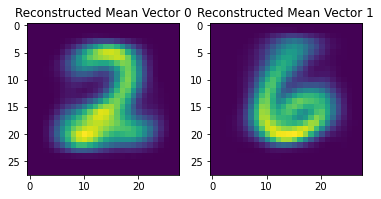

In [15]:
km_obj = KMeans(n_clusters=2,max_iter=100,init='random').fit(mnist_pca)
centers = km_obj.cluster_centers_
K_m_labels = km_obj.labels_
plt.figure(figsize=(6,6))
K_mean_re_1 = mu_reshape_transform(k_eigvectors,k_eigvals,centers[0,:],original_mean,28).T
plt.subplot(121)
plt.imshow(K_mean_re_1)
plt.title('Reconstructed Mean Vector 0')
plt.subplot(122)
K_mean_re_2 = mu_reshape_transform(k_eigvectors,k_eigvals,centers[1,:],original_mean,28).T
plt.imshow(K_mean_re_2)
plt.title('Reconstructed Mean Vector 1')
plt.show()

As we can see from the reconstructed K Means Mean vector plots above, we certainly have had some success in identifying the two main subsets of data. The figures in fact look very similar to the mean vectors reconstructed from the earlier implementation of GMM. 

### Kmeans Accuracy:

We can further understand the competence of the K means algorithm on the seperation task by running several random initializations of the algorithm. The chart below displays the results of 100 random initializations, each with a maximum iteration count of 100, and a limit of 10 optimal initialization center tests. The results are as follows:

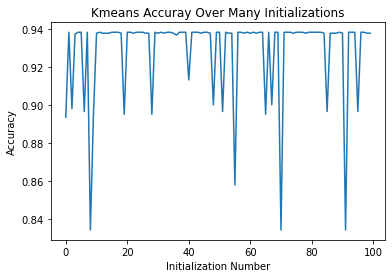

In [16]:
k_means_accuracy = []
for i in range(100):
    km_obj_i = KMeans(n_clusters=2,max_iter=200,init='random',n_init=10).fit(mnist_pca)
    centers = km_obj_i.cluster_centers_
    K_m_labels = km_obj_i.labels_
    K_m_labels1 = np.where(K_m_labels == 0,6,2)
    K_m_labels2 = np.where(K_m_labels == 0,2,6)
    number_of_samples = K_m_labels.shape[0]
    number_correct1 = np.sum(mnist_labels == K_m_labels1)
    number_correct2 = np.sum(mnist_labels == K_m_labels2)
    km_percent_correct1 = number_correct1/number_of_samples
    km_percent_correct2 = number_correct2/number_of_samples
    if km_percent_correct1 >  km_percent_correct2:
        km_percent = km_percent_correct1
    else:
         km_percent = km_percent_correct2
    k_means_accuracy.append(km_percent)

k_means_accuracy_array = np.array(k_means_accuracy)
plt.plot(k_means_accuracy_array)
plt.title('Kmeans Accuray Over Many Initializations')
plt.xlabel('Initialization Number')
plt.ylabel('Accuracy')
plt.show()

As we can see clearly, the kmeans algorithm does not display the consistency of the gaussian mixture model algorithm. The reason behind this is due to K means inherent properties of initialization sensitivity which leads it into local minima and is not guaranteed to find the global minimum of the cost function. Gaussian mixture modeling is also susceptible to initialization constraints. However, Gaussian mixture models are guaranteed to find the global minimum if given enough iterations. In the case of this dataset, as we saw above the 100 iterations was more than enough overhead to arrive at this maximum. Although our gaussian model took far less iterations to converge, it is notable that there is a large time difference in execution that makes kmeans compile far quicker for a given initialization.  

### GMM Accuracy Vs. Kmeans Accuracy:

In order to best visualize their differences below is the joint plot of each's accuracy rates. As we can see GMM is our clear and more consistent winner.

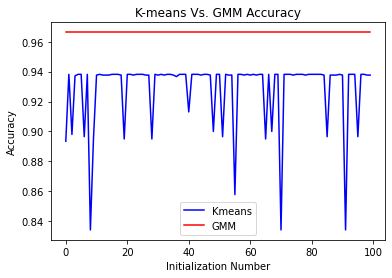

In [17]:
plt.plot(k_means_accuracy_array,c='b',label='Kmeans')
plt.plot(gmm_accuracy_array,c='r',label='GMM')
plt.title('K-means Vs. GMM Accuracy')
plt.xlabel('Initialization Number')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Although it would be interesting to compare the GMM and Kmeans implementation's various mis-match rates over these iterations, it would be difficult accomplish as each iteration could have swapped values for '2' or '6' as these unsupervised learning frameworks carry no importance to whether mean vector 0 is a two or a six from initialization to initialization. Thus, for these reasons I have only demonstrated the comparison of mis-classification rates on a single basis using a static random number seed to keep the plots reproducible and effectively comparable.